# Causal Bandits
### Chris Botica and Nick Tyler

In [1]:
import numpy as np
from torch import tensor
from pyro import sample, do
import pyro.distributions as dist
from time import time
import matplotlib.pyplot as plt

### 1. Intro

We have a multi-armed bandit (2 arms/machines), each with it's own prior payout probability distribution. Our agent wants to maximize the reward

![Multi-armed Bandit](multiarmedbandit.jpg)

This problem is treated as if each machine has its own hidden probability distribution and the agent applies a sampling strategy to learn this distribution (explore) while trying to pull on the "best" arm to maximize rewards (exploit). 

There exists multiple sampling strategies that balance exploration and exploitation but, traditionally, all of these treat the each variable as fully observable. 

Example of such models:


![Traditional Models](Model1.png)

However, we treat the environment as an unobserved confounder

![Our Model](Model2.png)

Specifically, we treat the environment as 2 confounders. In our problem, the casino manipulated the payout probabilites for each machine based on the users drunkness and whether or not the machine is blinking:

![Our Model with Blink Drunk](Model3.png)

The casino decides on the following payout probabilities for the machines as a function of the agent's drunkness, the machine's blinkiness, and the arm choice:   (need to update table....)

|       -       |   $Drunk = 0$  |        -       |   $Drunk = 1$  |        -       |
|:-------------:|:--------------:|:--------------:|:--------------:|:--------------:|
|       -       | $Blinking = 0$ | $Blinking = 1$ | $Blinking = 0$ | $Blinking = 1$ |
| $Machine = 1$ |      0.10      |      0.50      |      0.40      |      0.20      |
| $Machine = 2$ |      0.50      |      0.10      |      0.20      |      0.40      |

### 2. Environment

We have probabilities for the drunk, blink:

In [2]:
# Setup the environment
environment_probs = {
    'drunk': .5,
    'blinking': .5
}

Using these as an input we create our environment class

In [3]:
class Environment(object):

    def __init__(self, env_probabilities):
        self.env_probabilities = env_probabilities

    def observe(self):
        env = {}
        for key, value in self.env_probabilities.items():
            env[key] = sample(key, dist.Categorical(tensor([1 - value, value])))
        return env

We set our environment:

In [4]:
environment = Environment(environment_probs)

### 3. Bandit Simulator

The casino has the following hidden reward probabilities:

In [5]:
causal_bandit_probs = np.array([
    np.array([
        np.array([.1, .5]),
        np.array([.4, .2])
    ]),
    np.array([
        np.array([.5, .1]),
        np.array([.2, .4])
    ])
])

We use these and the environment to make our bandit simulator class

In [6]:
class ConfoundingBanditSimulator(object):

    def __init__(self, reward_probabilities):
        self.reward_probabilities = reward_probabilities

    def gambler_model(self, environment):  
        drunk = int(environment["drunk"])
        blinking = int(environment["blinking"])
        intuition = int(bool(drunk) ^ bool(blinking))  # xor(drunk, blinking)

        # Select arm based on intuition
        arm = sample('arm',dist.Delta(tensor(intuition)))

        # Get Reward
        reward_probability = self.reward_probabilities[arm][drunk][blinking]
        reward = sample('reward', dist.Bernoulli(reward_probability))

        return reward

    def __len__(self):
        return len(self.reward_probabilities)

Set our bandit simulator:

In [7]:
confoundingBandits = ConfoundingBanditSimulator(causal_bandit_probs)

### 4. Sampler

BaseSampler as a base for all our samplers

In [8]:
DRUNK = 'drunk'
BLINKING = 'blinking'


class BaseSampler(object):
    """
    A base class with standard methods used by more complex samplers.

    parameters:
    bandits: a bandit class with .pull method
    environment: an environment that can be .observe for variables
    """

    @staticmethod
    def _get_init_array(n):
        return np.zeros(n)

    def __init__(self, bandits, environment):
        self.bandits = bandits
        self.environment = environment
        self.wins = self.__class__._get_init_array(len(self.bandits))
        self.trials = self.__class__._get_init_array(len(self.bandits))
        self.N = 0
        self.choices = []
        self.current_scores = []
        self.observed_envs = []

    def initialize(self):
        self.wins = self.__class__._get_init_array(len(self.bandits))
        self.trials = self.__class__._get_init_array(len(self.bandits))
        self.N = 0
        self.choices = []
        self.current_scores = []
        self.observed_envs = []

    def update_parameters(self, choice, result, observed_env):
        self._update_wins_trials(choice, result, observed_env)
        self.current_scores.append(result)
        self.N += 1
        self.choices.append(choice)
        self.observed_envs.append(observed_env)

    def _update_wins_trials(self, choice, result, observed_env):
        self.wins[choice] += result
        self.trials[choice] += 1

    def sample_bandits(self, n=1):
        for k in range(n):
            self._pull_bandit()

    def _pull_bandit(self):
        observed_env = self.environment.observe()
        algo_choice = self._select_arm(observed_env)
        model = self.bandits.gambler_model
        intervention_model = do(model, {'arm':algo_choice})
        result = intervention_model(observed_env)
        self.update_parameters(algo_choice, result, observed_env)

    def _select_arm(self, observed_env):
        return 0
    

#### 4.1. Standard Thompson Sampling

TO DO: 
- Write out formulation for standard TS

In [9]:
class StandardThomspon(BaseSampler):

    def _select_arm(self, observed_env):
        choice = np.argmax([
                sample('arm' + str(i), dist.Beta(1 + self.wins[i], 1 + self.trials[i] - self.wins[i]))
                for i in range(len(self.bandits))
            ])
        return choice

#### 4.2. Causal Thompson Sampling

TO DO: 
- write out how we calculated ETT
- write out formulation of causal TS

In [10]:
class CausalThomspon(BaseSampler):

    @staticmethod
    def _get_init_array(n):
        return np.array([
            np.array([np.zeros(n), np.zeros(n)]),
            np.array([np.zeros(n), np.zeros(n)])
        ])

    def _update_wins_trials(self, choice, result, observed_env):
        drunk = observed_env[DRUNK]
        blinking = observed_env[BLINKING]
        self.wins[drunk][blinking][choice] += result
        self.trials[drunk][blinking][choice] += 1

    # Calculate P(Y=1 | X=x, Drunk = d, Blinking = b)
    def _cond_prob_y(self, x, d=-1, b=-1):
        if d == b == -1:  # meanining only condition on x
            y_vals = [self.current_scores[i] for i, x_val in enumerate(self.choices) if x_val == x]
        else:
            y_vals = [self.current_scores[i] for i, (x_val, env) in enumerate(zip(self.choices, self.observed_envs))
                      if x_val == x and env[DRUNK] == d and env[BLINKING] == b]

        if len(y_vals) == 0:
            return 0
        else:
            return sum(y_vals) / len(y_vals)

    # Calculate P(Drunk=d & Blink=b | X=x)
    def _cond_prob_db(self, d, b, x):
        no_events = np.sum([1 for i, (x_val, env) in enumerate(zip(self.choices, self.observed_envs))
                            if x_val == x and env[DRUNK] == d and env[BLINKING] == b])
        no_outcomes = np.sum([1 for i, x_val in enumerate(self.choices) if x_val == x])

        if no_outcomes == 0:
            return 0
        else:
            return no_events / no_outcomes

    def _select_arm(self, observed_env):
        # Get environment variables that we care about
        drunk = observed_env[DRUNK]
        blinking = observed_env[BLINKING]

        # Get the intuition for this trial:
        # Based on Bareinboim et. al., this is just the xor function of drunk and blinking
        intuition = int(bool(drunk) ^ bool(blinking))  # xor(drunk, blinking)

        # Estimate the payout for the counter-intuition: E(Y_(X=x')|X=x)
        counter_intuition = abs(intuition - 1)
        Q1 = np.sum([self._cond_prob_y(counter_intuition, drunk_val, blink_val)
                     * self._cond_prob_db(drunk_val, blink_val, counter_intuition)
                     for drunk_val in [0, 1] for blink_val in [0, 1]])

        # Estimate the payout for the intuition (posterior predictive): P(y|X=x)
        Q2 = self._cond_prob_y(intuition)

        w = [1, 1]  # initialize weights (per the paper)
        bias = 1 - abs(Q1 - Q2)  # weighting strength (per the paper)

        if Q1 > Q2:
            w[intuition] = bias  # per the paper
        else:
            w[counter_intuition] = bias

        # Get the #successes and # failures for each machine given the intuition:
        # Since we store the successes as wins[drunk][blinking] I want to get the possible drunkess and
        # blinkness that would yield our intuition (2 posibilities since we are doing inverse of xor)
        env_given_intuition = [[drunk, blinking],
                               [abs(drunk - 1), abs(blinking - 1)]]

        # Thus, env_given_intuition[k] corresponds to the drunk&blink values
        # that yield that intuition
        wins = sum([self.wins[drunk][blinking] for drunk, blinking in env_given_intuition])
        trials = sum([self.trials[drunk][blinking] for drunk, blinking in env_given_intuition])
        alpha = 1 + wins
        beta = 1 + trials - wins

        # Choose arm:
        choice = np.argmax([sample('arm1', dist.Beta(alpha[0], beta[0])) * w[0],
                            sample('arm2', dist.Beta(alpha[1], beta[1])) * w[1]])

        return choice

Set our samplers:

In [11]:
standard_sampler = StandardThomspon(confoundingBandits, environment)
causal_sampler = CausalThomspon(confoundingBandits, environment)

### 5. Regret and Prob of picking best arm

In [12]:
def regret_causal(probabilities, choices):
    regret_arr = []
    last = 0
    for i in range(0, len(probabilities)):
        prob = probabilities[i]
        w_opt = prob.max()
        reg = w_opt - prob[choices[i]]
        regret_arr.append(reg + last)
        last = reg + last
    return np.array(regret_arr)

# Probability of Selecting Best Arm
def prob_best_arm_causal(probabilities, choices):
    was_best_selected = [int(np.argmax(prob)==choice) for _,(prob, choice) in enumerate(zip(probabilities, choices))]
    cumulative_best_selected = np.array(was_best_selected).cumsum()
    prob_best = [cumulative_best_selected[i]/(i+1) for i in range(len(cumulative_best_selected))]
    return prob_best

### 6. Run simulation

In [13]:
def run_simulation(trials, pulls, sampler, true_probabilities):
    exp_total_regret = np.zeros(pulls)
    exp_prob_best_arm = np.zeros(pulls)
    
    for trial in range(trials):
        sampler.initialize()
        sampler.sample_bandits(pulls)
        
        pull_probabilities = [
            true_probabilities[int(env['drunk'])][int(env['blinking'])]
            for env in sampler.observed_envs
        ]
        
        exp_total_regret += regret_causal(pull_probabilities, sampler.choices)
        exp_prob_best_arm += prob_best_arm_causal(pull_probabilities, sampler.choices)
    
    return exp_total_regret, exp_prob_best_arm
        
        

n_pulls = 1000 # number pulls for a trial
n_trials = 5 # number of trials/times we repeat the experiment to get E[regret]

exp_tot_standard_regret, exp_standard_prob_best_arm = run_simulation(
    n_trials, n_pulls, standard_sampler, causal_bandit_probs
)
exp_tot_causal_regret, exp_causal_prob_best_arm = run_simulation(
    n_trials, n_pulls, causal_sampler, causal_bandit_probs
)

Plot Regret

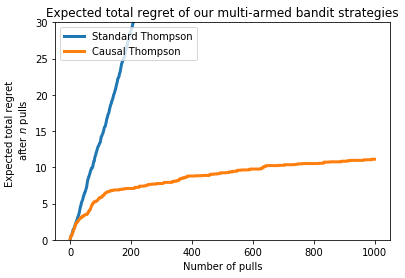

In [14]:
StandardTS_regret_plot = plt.plot(exp_tot_standard_regret/n_trials, lw =3,
                         label = "Standard Thompson")
CausalTS_regret_plot = plt.plot(exp_tot_causal_regret/n_trials, lw =3,
                       label = "Causal Thompson")
plt.ylim(bottom=0,top = 30)
plt.title("Expected total regret of our multi-armed bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()

Plot Prob of selecting best arm

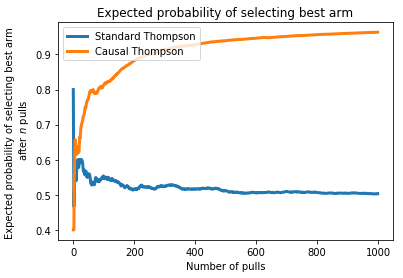

In [15]:
StandardTS_prob_plot = plt.plot(np.divide(exp_standard_prob_best_arm,n_trials), lw =3,
                         label = "Standard Thompson")
CausalTS_prob_plot = plt.plot(np.divide(exp_causal_prob_best_arm,n_trials), lw =3,
                       label = "Causal Thompson")
#plt.ylim(bottom=0,top = 30)
plt.title("Expected probability of selecting best arm")
plt.xlabel("Number of pulls")
plt.ylabel("Expected probability of selecting best arm \n after $n$ pulls")
plt.legend(loc="upper left");
plt.show()